👁️ Training Mycelium with Spatial Attention...
Ep 000 | Test Acc: 14.2% | Core Veterans: 0
Ep 050 | Test Acc: 89.4% | Core Veterans: 36
Ep 100 | Test Acc: 91.7% | Core Veterans: 36
Ep 150 | Test Acc: 91.7% | Core Veterans: 36
Ep 200 | Test Acc: 90.8% | Core Veterans: 36
Ep 250 | Test Acc: 90.8% | Core Veterans: 36

🏆 FINAL RECORD (Attention + Core): 92.2%


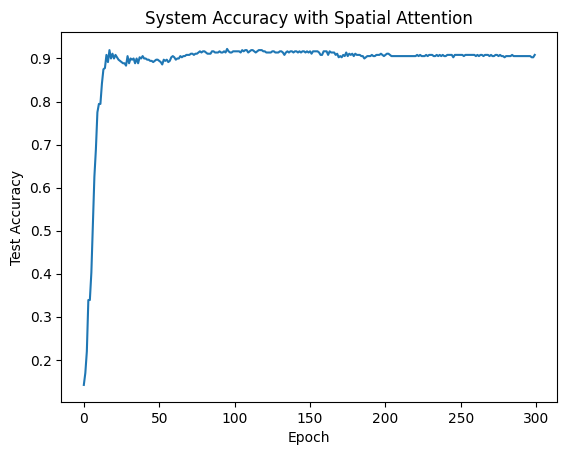

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class VisionaryMycelium:
    def __init__(self, n_agents, input_dim, output_dim):
        self.n_agents = n_agents
        self.input_dim = int(np.sqrt(input_dim)) # Expecting 8 for 8x8 images
        self.output_dim = output_dim

        # Weights (8x8 kernels)
        self.weights = np.random.randn(n_agents, 8, 8) * 0.2
        self.ema_weights = self.weights.copy()
        self.class_allegiance = np.random.randint(0, output_dim, n_agents)
        self.performance_score = np.zeros(n_agents)
        self.is_frozen = np.zeros(n_agents, dtype=bool)
        self.global_best_acc = 0

    def _get_shifts(self, X_batch):
        """Creates 5 image variations: center + 4 shifts by 1 pixel"""
        X_img = X_batch.reshape(-1, 8, 8)
        shifts = [X_img] # Original

        # Shifts (zero-padding)
        shifts.append(np.pad(X_img, ((0,0),(1,0),(0,0)), mode='constant')[:,:-1,:]) # Down
        shifts.append(np.pad(X_img, ((0,0),(0,1),(0,0)), mode='constant')[:,1:,:])  # Up
        shifts.append(np.pad(X_img, ((0,0),(0,0),(1,0)), mode='constant')[:,:,:-1]) # Right
        shifts.append(np.pad(X_img, ((0,0),(0,0),(0,1)), mode='constant')[:,:,1:])  # Left
        return shifts

    def forward(self, X, use_ema=True, noise_level=0.0):
        w_orig = self.ema_weights if use_ema else self.weights
        w = w_orig.copy()

        if noise_level > 0:
            noise = np.random.randn(*w.shape) * noise_level
            noise[self.is_frozen] = 0
            w += noise

        # Get all shift variations
        X_shifts = self._get_shifts(X)

        # Calculate activations for each shift and take the maximum (Spatial MaxPooling)
        max_acts = np.zeros((X.shape[0], self.n_agents))

        for x_s in X_shifts:
            # Calculate dot product for tensors (batch, 8, 8) x (agents, 8, 8)
            current_acts = np.tensordot(x_s, w, axes=((1,2), (1,2)))
            current_acts = np.maximum(0, current_acts - 0.35)
            max_acts = np.maximum(max_acts, current_acts)

        votes = np.zeros((X.shape[0], self.output_dim))
        authority = np.square(np.log1p(np.maximum(0, self.performance_score)))

        for i in range(self.n_agents):
            boost = 1.6 if self.is_frozen[i] else 1.0
            votes[:, self.class_allegiance[i]] += max_acts[:, i] * (boost + authority[i])

        return votes, max_acts

    def train_epoch(self, X, y, epoch, total_epochs):
        noise = 0.03 * (1.0 - (epoch / total_epochs))
        lr = 0.05 * (0.994 ** epoch)

        votes, acts = self.forward(X, use_ema=False, noise_level=noise)
        preds = np.argmax(votes, axis=1)
        curr_acc = accuracy_score(y, preds)

        # Freeze the core agents when records are broken
        if curr_acc > self.global_best_acc and epoch > 25:
            self.global_best_acc = curr_acc
            available = np.where(~self.is_frozen)[0]
            if len(available) > 10:
                # Select top 1% of performing non-frozen agents to freeze
                top_new = available[np.argsort(self.performance_score[available])[-int(self.n_agents*0.01):]]
                self.is_frozen[top_new] = True

        # Training process
        system_wrong = (preds != y)
        X_img = X.reshape(-1, 8, 8)

        for i in range(self.n_agents):
            if self.is_frozen[i] and np.random.rand() > 0.05: continue

            cls = self.class_allegiance[i]
            fire = acts[:, i] > 0
            if not np.any(fire): continue

            # Specialize on system errors (Hard Example Mining)
            mask_unique = fire & system_wrong & (cls == y)
            if np.any(mask_unique):
                self.performance_score[i] += np.sum(mask_unique) * 3.0
                target = np.mean(X_img[mask_unique], axis=0)
                self.weights[i] += lr * 2.0 * (target - self.weights[i])

            # General Hebbian Learning
            precision = np.sum((cls == y) & fire) / (np.sum(fire) + 1e-6)
            if precision > 0.75:
                self.performance_score[i] += 1.2
                self.weights[i] += lr * (np.mean(X_img[(cls == y) & fire], axis=0) - self.weights[i])
                self.weights[i] *= 0.998
            else:
                self.performance_score[i] -= 1.3

        self.ema_weights = 0.95 * self.ema_weights + 0.05 * self.weights

        # Evolution (Selection and Mutation)
        if epoch > 20:
            idx = np.argsort(self.performance_score)
            # Identify low-performing candidates that aren't frozen
            kill_candidates = [k for k in idx if not self.is_frozen[k]][:int(self.n_agents * 0.06)]
            elites = idx[-int(self.n_agents * 0.15):]
            for v in kill_candidates:
                parent = np.random.choice(elites)
                self.weights[v] = self.weights[parent].copy() + np.random.randn(8, 8) * 0.04
                self.class_allegiance[v] = self.class_allegiance[parent]
                self.performance_score[v] = 0

        return curr_acc

# --- EXECUTION ---
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data/16.0, digits.target, test_size=0.2, random_state=42)

model = VisionaryMycelium(1800, 64, 10)
history = []

print("👁️ Training Mycelium with Spatial Attention...")

for e in range(300):
    train_acc = model.train_epoch(X_train, y_train, e, 300)

    test_votes, _ = model.forward(X_test, use_ema=True)
    test_acc = accuracy_score(y_test, np.argmax(test_votes, axis=1))
    history.append(test_acc)

    if e % 50 == 0:
        veterans = np.sum(model.is_frozen)
        print(f"Ep {e:03d} | Test Acc: {test_acc:.1%} | Core Veterans: {veterans}")

print(f"\n🏆 FINAL RECORD (Attention + Core): {max(history):.1%}")

plt.plot(history)
plt.title("System Accuracy with Spatial Attention")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.show()

#AUTHOR: NURZHANOV AKNIET

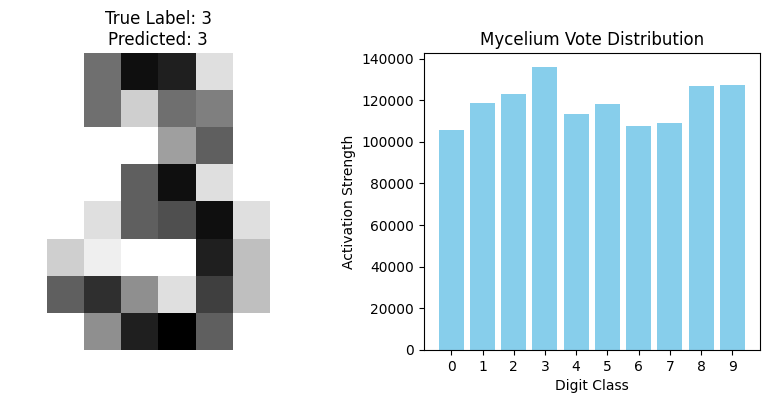

✅ Success! The Mycelium correctly identified the digit 3


In [13]:
def verify_random_prediction(model, X_test, y_test):
    # Select a random index
    idx = np.random.randint(0, len(X_test))
    sample_img = X_test[idx]
    true_label = y_test[idx]

    # Get model prediction
    # We only need the votes for classification
    votes, _ = model.forward(sample_img.reshape(1, -1), use_ema=True)
    predicted_label = np.argmax(votes[0])

    # Visualization
    plt.figure(figsize=(8, 4))

    # Left side: The digit image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img.reshape(8, 8), cmap='gray_r')
    plt.title(f"True Label: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')

    # Right side: Distribution of agent votes across classes
    plt.subplot(1, 2, 2)
    plt.bar(range(10), votes[0], color='skyblue')
    plt.xticks(range(10))
    plt.title("Mycelium Vote Distribution")
    plt.xlabel("Digit Class")
    plt.ylabel("Activation Strength")

    plt.tight_layout()
    plt.show()

    if true_label == predicted_label:
        print(f"✅ Success! The Mycelium correctly identified the digit {predicted_label}")
    else:
        print(f"❌ Error. The Mycelium mistook {true_label} for {predicted_label}")

# Run the verification
verify_random_prediction(model, X_test, y_test)

#AUTHOR: NURZHANOV AKNIET